In [1]:
import equinox as eqx
from jax import dtypes, vmap
import jax.numpy as jnp
import jax.random as random
from jpdenet.grad import egrad
from jpdenet.loss import ic_loss, bc_loss, MSE
from jpdenet.model import MLP
from jpdenet.train import create_batches
import matplotlib.pyplot as plt
import numpy as np
import optax
from typing import Tuple

# set random seed
PRNGKEY = random.PRNGKey(1)

# 1D problem
ndims = 1

In [2]:
# define model
model = MLP(PRNGKEY, (ndims + 1, 20, 20, 1), output_activation="abs")

In [3]:
# define loss function


def residual_loss(model, xb):
    """
    1D scalar advection equation
    """
    grads = egrad(vmap(model, in_axes=0))(xb)
    dudt = grads[:, 1]
    dudx = grads[:, 0]
    return MSE(dudt + dudx)


def u0(x, mode: str = "square"):
    """
    initial condition
    """
    if mode == "square":
        return jnp.where(x < 0.25, 0.0, jnp.where(x > 0.75, 0.0, 1.0))
    elif mode == "sinus":
        return 0.5 * jnp.sin(2.0 * jnp.pi * x) + 0.5
    else:
        raise ValueError(f"mode {mode} not recognized")


def loss(
    model, xb, regularization_strength: float = 0.0, regularization_mode: str = "l1"
):
    """
    combines all three losses
    args:
        model: model
        xb: input batch
        regularization_strength: strength of regularization
        regularization_mode: type of regularization, either "l1" or "l2"
    """
    out = residual_loss(model, xb)
    out += ic_loss(u0, model, xb)
    out += bc_loss(model, xb, mode="periodic")
    if regularization_strength > 0.0:
        out += regularization_strength * model.regularizer(mode=regularization_mode)
    return out

In [4]:
# define function for training
def train(
    key: dtypes.prng_key,
    model: eqx.Module,
    optim: optax.GradientTransformation,
    train_data: jnp.ndarray,
    n_epochs: int,
    n_batches: int,
    print_every: int = -1,
) -> Tuple[eqx.Module, list]:
    """
    args:
        key: PRNG key
        model: neural network model
        optim: valid optax optimizer
        train_data: sample points in space where each column is the alue of the spatial coordinate. the last column is the time coordinate
        n_epochs: number of epochs
        n_batches: number of batches
        print_every: print loss every print_every epochs
    returns:
        model: trained model
        loss_values: list of loss values accumulated during training
    """
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def take_step(model, opt_state, xb):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, xb)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    loss_values = []
    for epoch in range(n_epochs):
        key, _ = random.split(key)
        for xb in create_batches(key, train_data, n_batches):
            model, opt_state, loss_value = take_step(model, opt_state, xb)
            loss_values.append(loss_value)
        if (epoch + 1) % print_every == 0:
            print(
                f"epoch {epoch + 1:3d}, loss {loss_values[-1]:10.5f}, learning rate {scheduler(opt_state[1].count):10.5f}"
            )

    return model, loss_values

In [5]:
# set hyperparameters
n_epochs = 40
n_data = 10000
batch_size = 100
print_every = 5

# generate data
train_data = random.uniform(PRNGKEY, (n_data, ndims + 1))

In [6]:
scheduler = optax.exponential_decay(
    init_value=1e-2, transition_steps=batch_size, decay_rate=0.99
)
optim = optax.adam(learning_rate=scheduler)

In [7]:
model, loss_values = train(
    key=PRNGKEY,
    model=model,
    optim=optim,
    train_data=train_data,
    n_epochs=n_epochs,
    n_batches=n_data // batch_size,
    print_every=print_every,
)

epoch   5, loss    0.03258, learning rate    0.00951
epoch  10, loss    0.02455, learning rate    0.00904
epoch  15, loss    0.00924, learning rate    0.00860
epoch  20, loss    0.01069, learning rate    0.00818
epoch  25, loss    0.00661, learning rate    0.00778
epoch  30, loss    0.00591, learning rate    0.00740
epoch  35, loss    0.01024, learning rate    0.00703
epoch  40, loss    0.01891, learning rate    0.00669


Text(0, 0.5, 'loss')

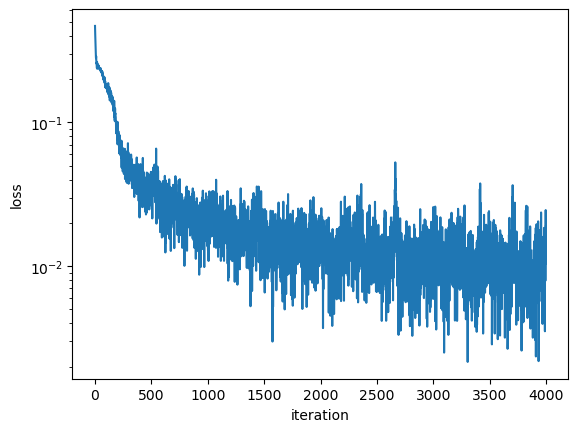

In [8]:
plt.plot(loss_values)
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("loss")

Text(0.5, 0, 'x')

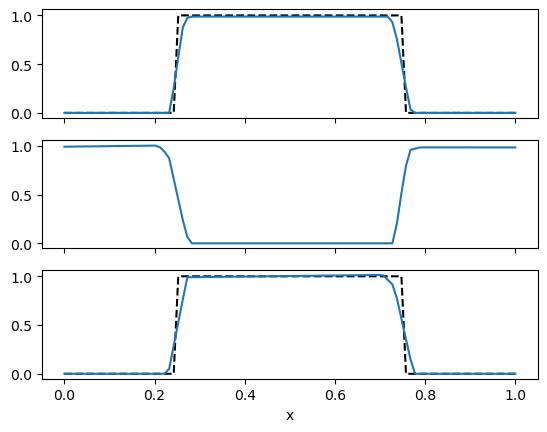

In [9]:
fix, axs = plt.subplots(3, sharex=True, sharey=True)

# plotting mesh
x = np.linspace(0, 1, 100)


def model_viewer(model, x: jnp.ndarray, t: float = 0.0):
    X = np.empty((x.shape[0], 2))
    X[:, 0] = x
    X[:, 1] = t
    return vmap(model, in_axes=0)(X)


axs[0].plot(x, u0(x), color="k", linestyle="--")
axs[0].plot(x, model_viewer(model, x, t=0.0))
axs[1].plot(x, model_viewer(model, x, t=0.5))
axs[2].plot(x, u0(x), color="k", linestyle="--")
axs[2].plot(x, model_viewer(model, x, t=1.0))
axs[2].set_xlabel("x")